In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [2]:
path_template = 'template/pattern.png'
template = cv2.imread(path_template, cv2.IMREAD_GRAYSCALE)

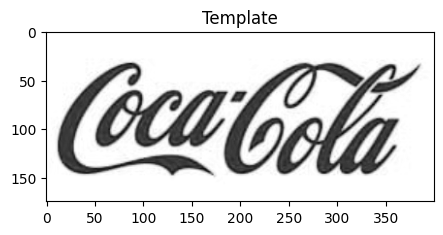

In [3]:
plt.figure(figsize=(5,5))
plt.imshow(template, cmap='gray')
plt.title('Template')
plt.show()

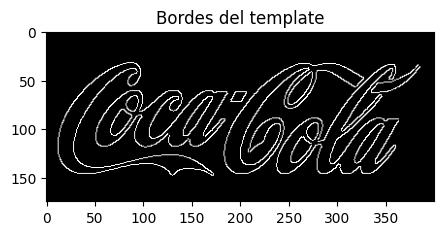

In [4]:
bordes_template = cv2.Canny(template, 220, 260, apertureSize = 3)
plt.figure(figsize=(5,5))
plt.imshow(bordes_template,cmap='gray')
plt.title('Bordes del template')
plt.show()

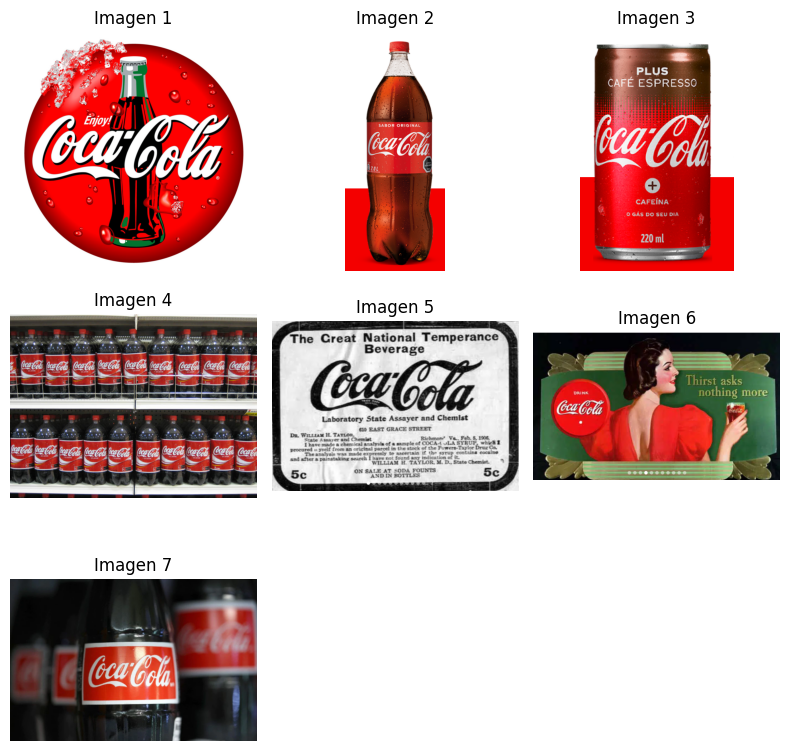

In [5]:

path_base = 'images/'
imagenes_rutas = [f for f in os.listdir(path_base) if f.endswith(('jpg', 'png'))] 

plt.figure(figsize=(8,8))

for idx, img_name in enumerate(imagenes_rutas):
    img = cv2.imread(path_base + img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    row = idx // 3 + 1
    col = idx % 3 + 1

    plt.subplot(3, 3, 3*(row-1) + col)
    plt.axis('off')
    plt.title("Imagen " + str(idx+1))
    plt.imshow(img)

plt.tight_layout()
plt.show()


In [6]:

def generar_escalas(imagen, escala_min_porc, escala_max_porc, porc_salto):

    width_original, height_original = imagen.shape[1], imagen.shape[0]
    rangos_escalas = np.arange(escala_min_porc, escala_max_porc + porc_salto, porc_salto)

    img_escalas = [
        cv2.resize(
            imagen,
            (
                int(width_original * escala / 100),
                int(height_original * escala / 100)
            ),
            interpolation=cv2.INTER_AREA if escala <= 100 else cv2.INTER_CUBIC
        )
        for escala in rangos_escalas
    ]

    return img_escalas


Tamaño de imagen:  (87, 200)


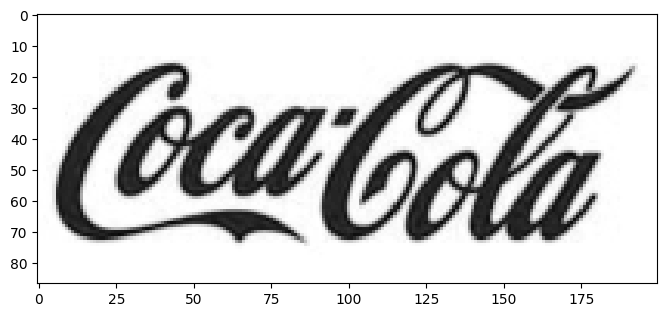

Tamaño de imagen:  (175, 400)


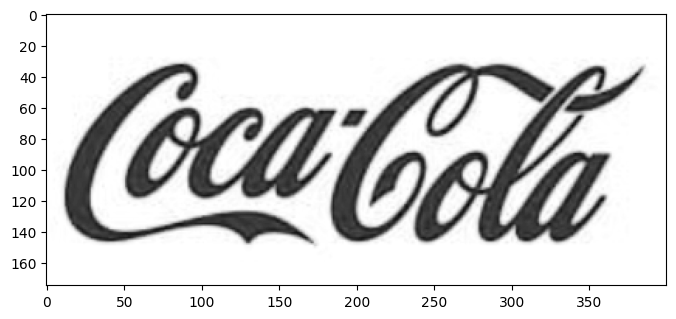

Tamaño de imagen:  (262, 600)


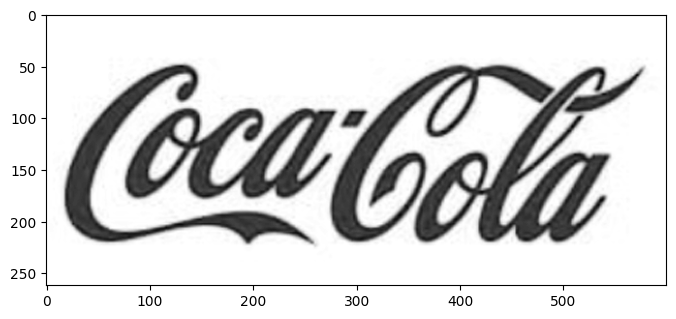

Tamaño de imagen:  (350, 800)


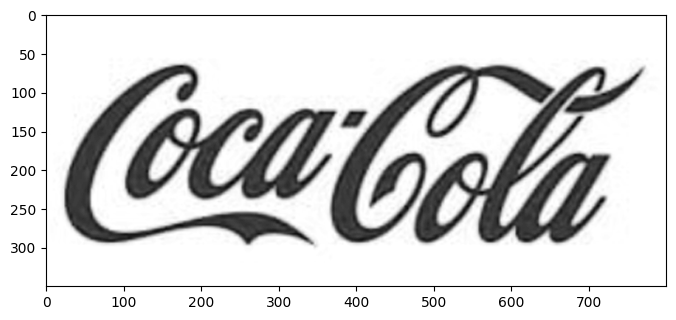

Tamaño de imagen:  (437, 1000)


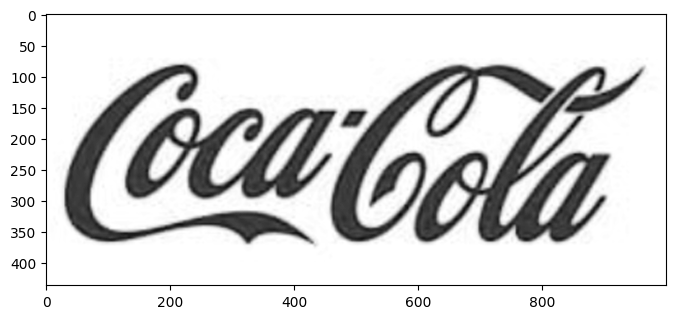

Tamaño de imagen:  (525, 1200)


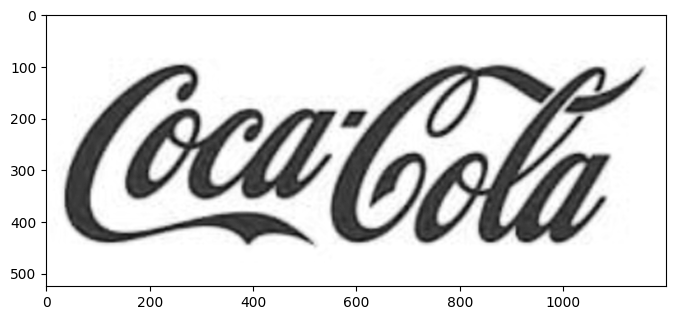

In [7]:
img_escaladas = generar_escalas(template, 50, 300, 50)

for img in img_escaladas:
    print("Tamaño de imagen: ", img.shape)   
    plt.figure(figsize=(8,10))
    plt.imshow(img,cmap='gray')
    plt.show()    

Tamaño de imagen:  (87, 200)


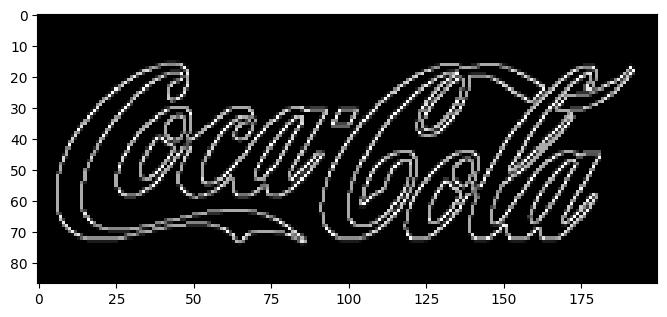

Tamaño de imagen:  (175, 400)


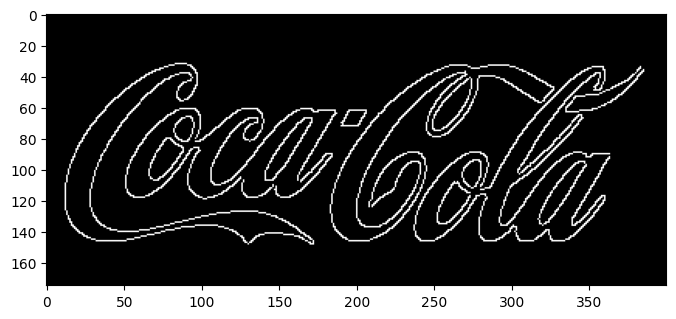

Tamaño de imagen:  (262, 600)


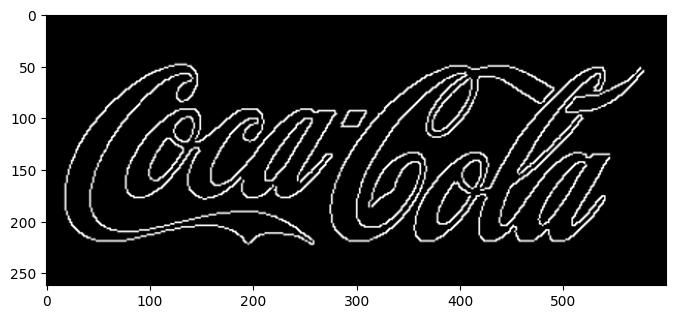

Tamaño de imagen:  (350, 800)


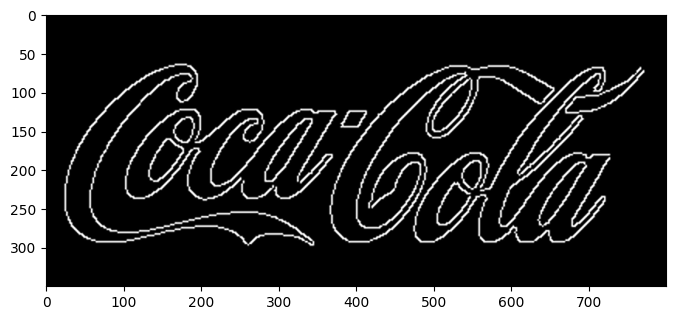

Tamaño de imagen:  (437, 1000)


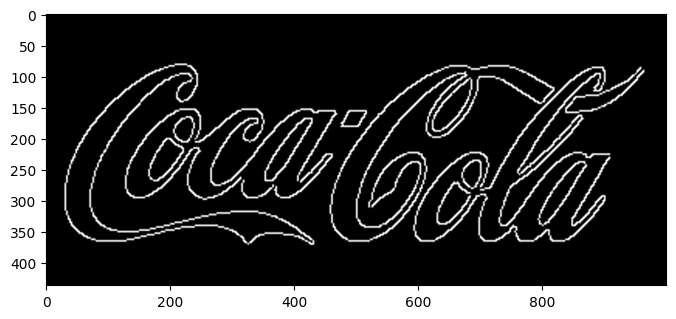

Tamaño de imagen:  (525, 1200)


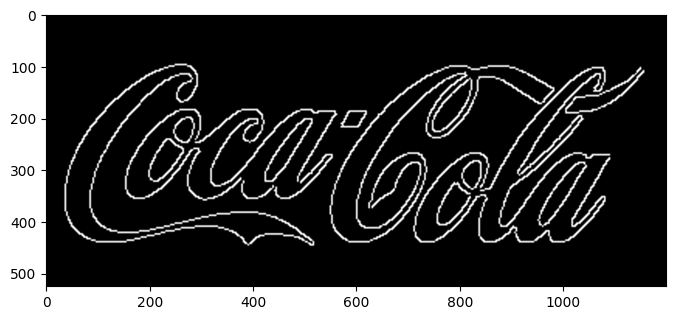

In [8]:
img_escaladas = generar_escalas(bordes_template, 50, 300, 50)

for img in img_escaladas:
    
    print("Tamaño de imagen: ", img.shape)   
    plt.figure(figsize=(8,10))
    plt.imshow(img,cmap='gray')
    plt.show()

In [9]:
def detectarLogo(template_in, imagen, method=cv2.TM_CCOEFF_NORMED, mostrar_escalas=False, umbral=None):
    
    color_box = (0, 255, 0)
    
    template_canny = cv2.Canny(template_in, 260, 260, apertureSize=3)
    imagen_gray = cv2.cvtColor(imagen, cv2.COLOR_RGB2GRAY)
    imagen_canny = cv2.Canny(imagen_gray, 260, 260, apertureSize=3)

    w_temp, h_temp = template_in.shape[::-1]
    w_img, h_img = imagen_gray.shape[::-1]
    
    factor_w, factor_h = w_img/w_temp, h_img/h_temp
    ratio = w_img / h_img
    min_factor, max_factor, cant_steps = 60, 95, 20

    if ratio > 1:
        min_factor, max_factor = 10, 15
    if ratio > 1.45:
        min_factor, max_factor = 30, 60

    min_px_w = 120
    min_factor_px = int((min_px_w*100) / (w_temp*factor_w))
    min_factor = max(min_factor_px, min_factor)

    fact_lim_max = int((w_img*100) / (factor_w * w_temp))
    max_factor = min(max_factor, fact_lim_max)

    templates_escalas = generar_escalas(template_canny, int(factor_w*min_factor), int(factor_w*max_factor), (factor_w*cant_steps))

    if mostrar_escalas:
        for template_esc in templates_escalas:
            plt.figure(figsize=(8,8))
            plt.axis('off')
            plt.imshow(template_esc, cmap='gray')
            plt.show()

    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        mejor_score = float('inf')
    else:
        mejor_score = float('-inf')

    img_salida, tamanio_template_match, confianza = imagen.copy(), "", 0

    for template_esc in templates_escalas:
        match = cv2.matchTemplate(imagen_canny, template_esc, method)
        cv2.normalize(match, match, 0, 1, cv2.NORM_MINMAX, -1)
        w, h = template_esc.shape[::-1]
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(match)
        
        if umbral is None:
            if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
                top_left = min_loc
                score = min_val
            else:
                top_left = max_loc
                score = max_val

            if (method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED] and score <= mejor_score) or (score >= mejor_score):
                mejor_score = score

                if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
                    confianza = (1 - mejor_score) * 100
                else:
                    confianza = mejor_score * 100

                bottom_right = (top_left[0] + w, top_left[1] + h)
                tamanio_template_match = f"Mejor match con template a resolución height: {h} - width: {w}"
                img_salida = imagen.copy()
                cv2.rectangle(img_salida, top_left, bottom_right, color_box, 4)
                cv2.putText(img_salida, f"{confianza:.3f}", (top_left[0], top_left[1] - 12), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color_box, 2)
        else:
            if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
                locs = np.where(match <= umbral)
            else:
                locs = np.where(match >= umbral)

            for pt in zip(*locs[::-1]):
                cv2.rectangle(img_salida, pt, (pt[0] + w, pt[1] + h), color_box, 2)
                score_at_point = match[pt[::-1]]
                
                if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
                    score_conf = (1 - score_at_point) * 100
                else:
                    score_conf = score_at_point * 100

                cv2.putText(img_salida, f"{score_conf:.1f}%", (pt[0], pt[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color_box, 2)

    plt.figure(1, figsize=(10, 10))
    plt.imshow(img_salida)
    plt.show()

imagen  COCA-COLA-LOGO.jpg  .Shape:  (1389, 1389, 3)


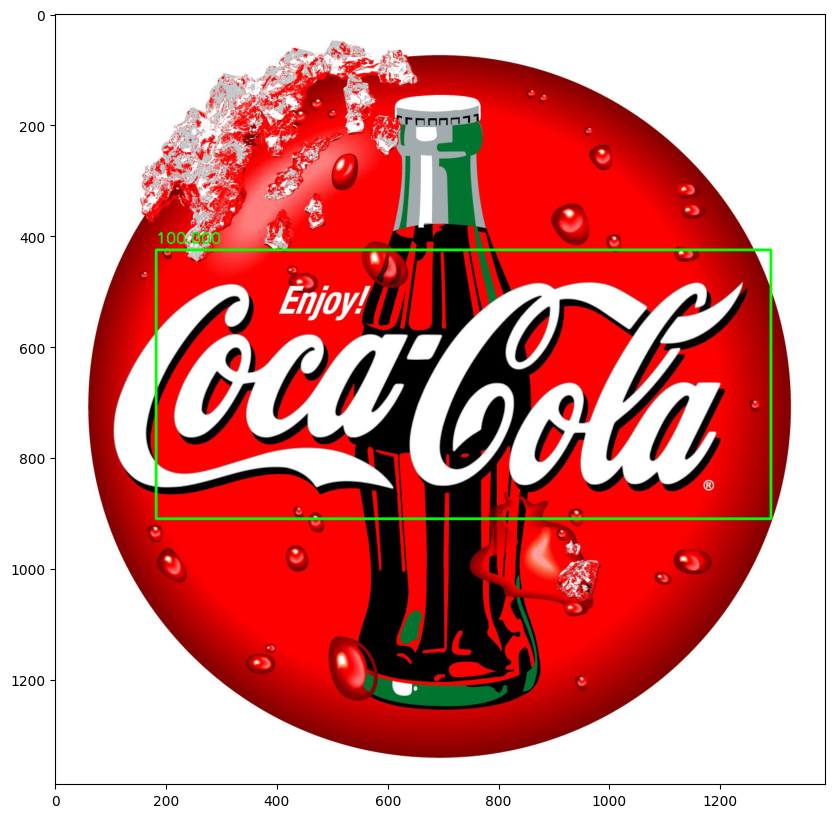

imagen  coca_logo_1.png  .Shape:  (500, 207, 3)


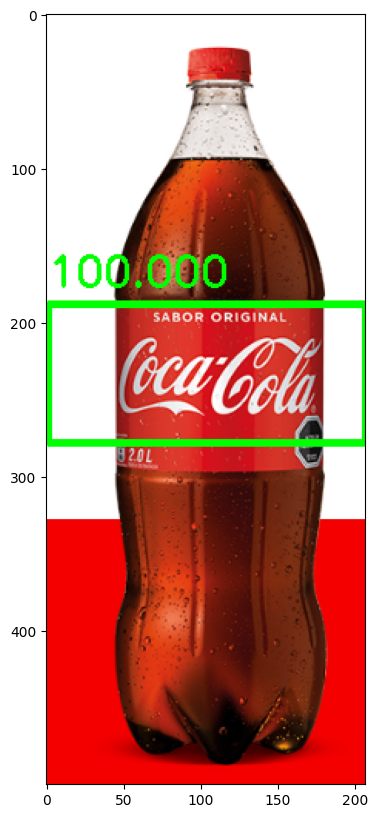

imagen  coca_logo_2.png  .Shape:  (363, 233, 3)


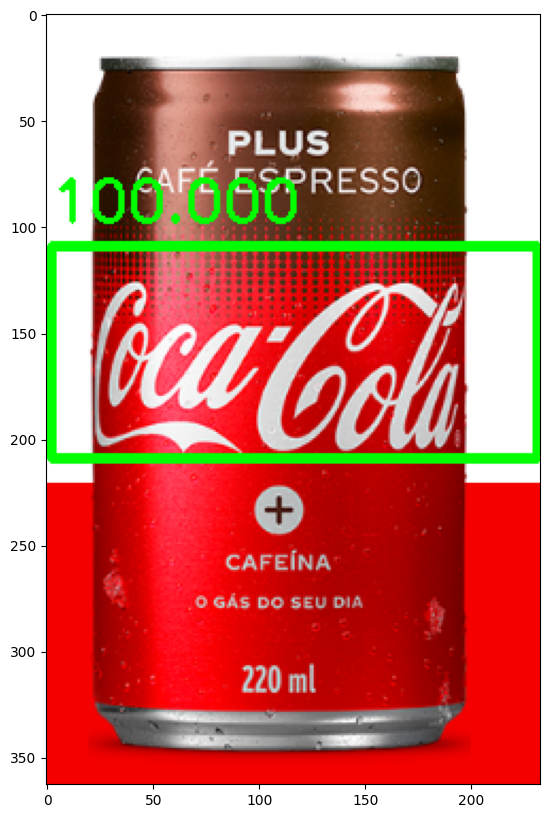

imagen  coca_multi.png  .Shape:  (598, 799, 3)


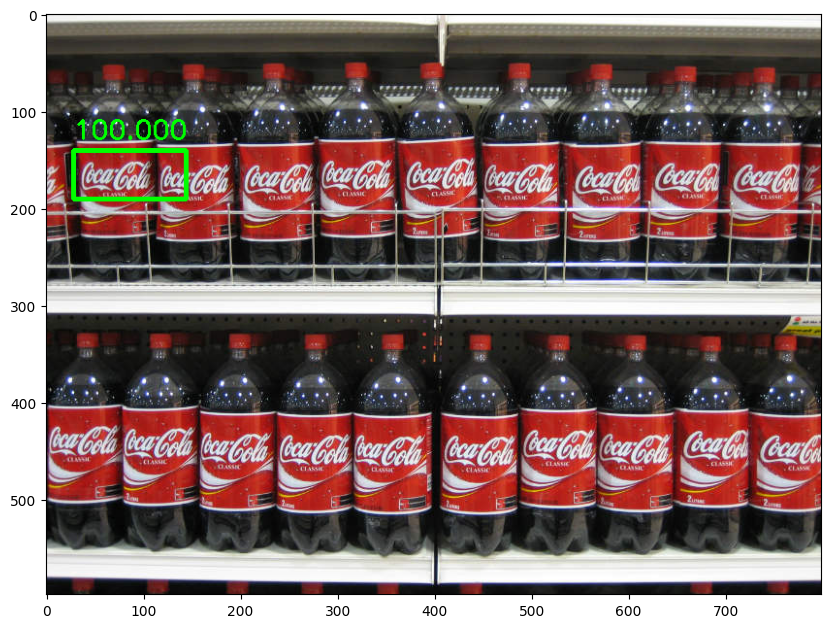

imagen  coca_retro_1.png  .Shape:  (493, 715, 3)


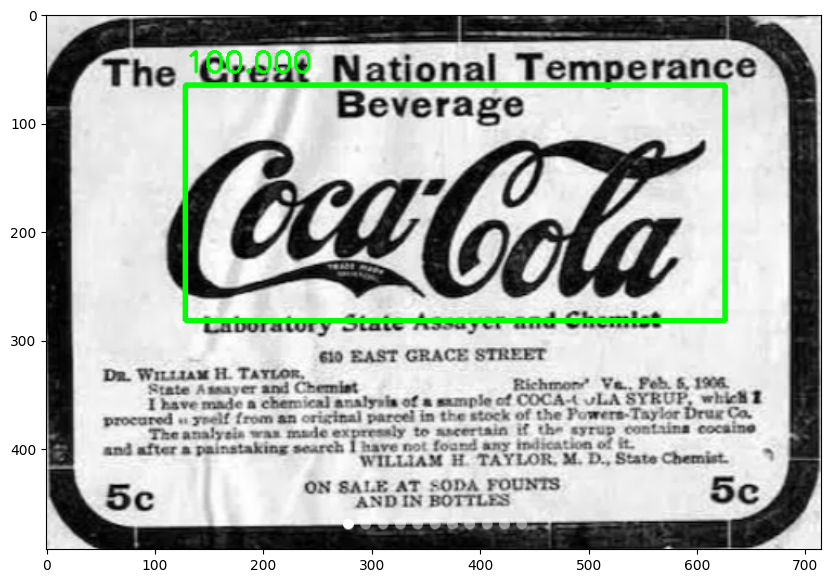

imagen  coca_retro_2.png  .Shape:  (429, 715, 3)


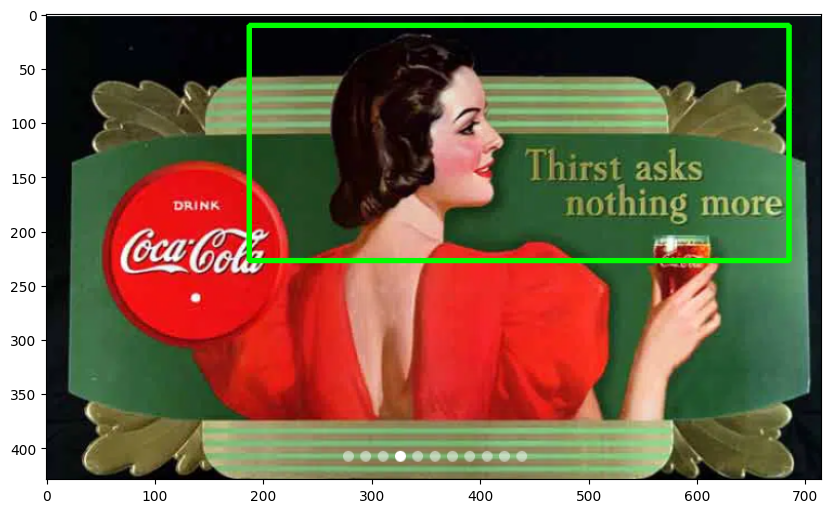

imagen  logo_1.png  .Shape:  (450, 687, 3)


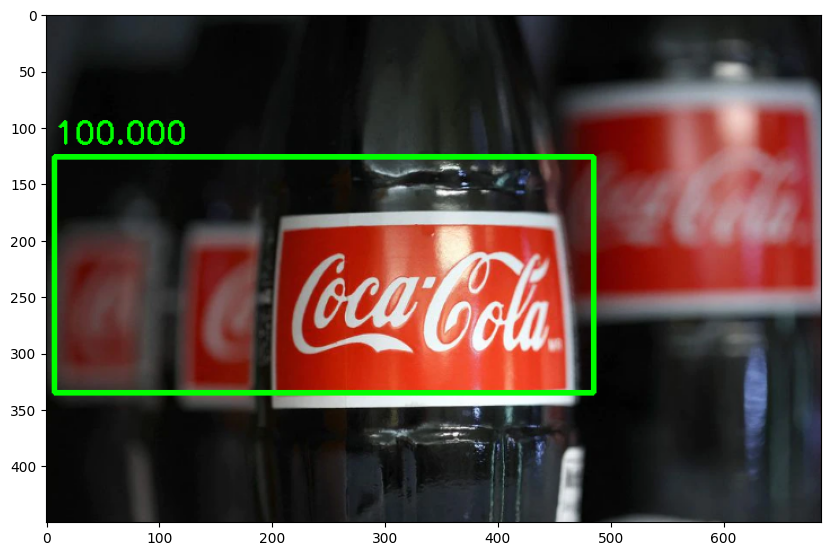

In [10]:
for img_name in imagenes_rutas:
    img = cv2.imread(path_base+img_name)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    print("imagen ",img_name ," .Shape: ",img.shape)
    detectarLogo(template_in=template,imagen=img,method = cv2.TM_CCOEFF_NORMED)

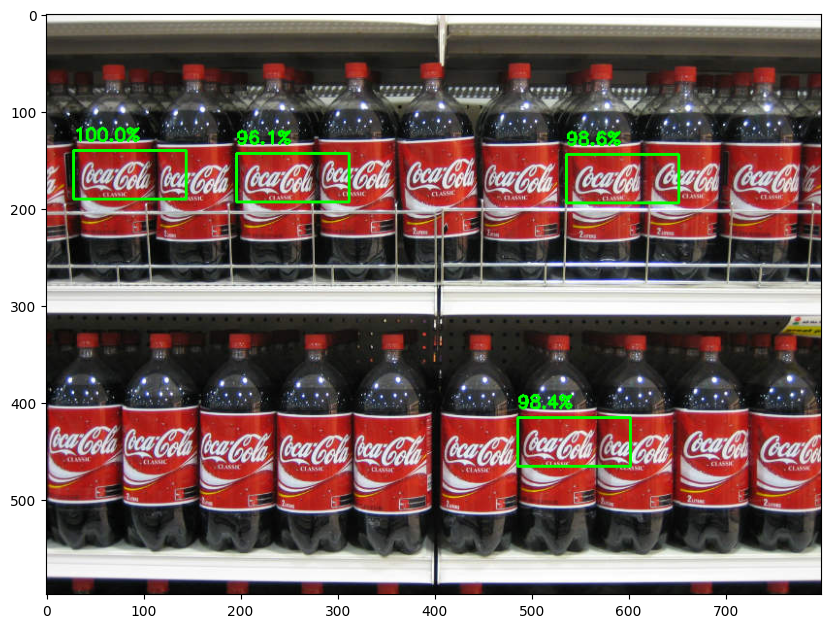

In [11]:
img_name = "coca_multi.png"
img = cv2.imread(path_base+img_name)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
detectarLogo(template_in=template, imagen=img,method =cv2.TM_CCOEFF_NORMED,mostrar_escalas=False,umbral=0.96)